## Lime Explainability
### Imports

In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import numpy as np
import os, json

import torch
from torchvision import models, transforms
from torch.autograd import Variable
import torch.nn.functional as F

### Get HW Device

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(device))

NVIDIA GeForce RTX 3080


### Load Test Image

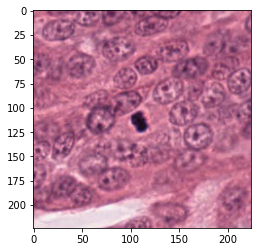

In [3]:
img_path = '../model_dev/Data_CMC_COADEL_224_1/val/Mitosis/10003.jpg'

def get_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB') 
        
img = get_image(img_path)
plt.imshow(img)

### Convert to a Pytorch Tensor

In [4]:
# resize and take the center part of image to what our model expects
def get_input_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])       
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ])    

    return transf

def get_input_tensors(img):
    transf = get_input_transform()
    # unsqeeze converts single image to batch of 1
    return transf(img).unsqueeze(0)

### Load Model
Load pretrained model, and modify softmax output layer for only having 2 classes. 

In [5]:
file_path='../model_dev/vgg16_ft.pth'

model = models.vgg16(weights=None)
num_features = model.classifier[6].in_features
features = list(model.classifier.children())[:-1]
features.extend([nn.Linear(num_features, 2)])
model.classifier = nn.Sequential(*features)

model.load_state_dict(torch.load(file_path))

<All keys matched successfully>

In [6]:
img_input = get_input_tensors(img)
model.eval()
model = model.to(device)
img_input = img_input.to(device)

In [7]:
output = model(img_input) #.to(device)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)

pred_label_idx.squeeze_()
predicted_label = str(pred_label_idx.item())
print(output)
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

tensor([[9.9924e-01, 7.6119e-04]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
Predicted: 0 ( 0.9992388486862183 )


In [8]:
def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])    

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    

    return transf    

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

In [9]:
def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)
    
    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

In [10]:
test_pred = batch_predict([pill_transf(img)])
test_pred.squeeze().argmax()

0

### Import Lime

In [11]:
from lime import lime_image

In [12]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                         batch_predict, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [13]:
from skimage.segmentation import mark_boundaries

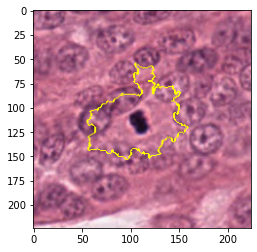

In [14]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

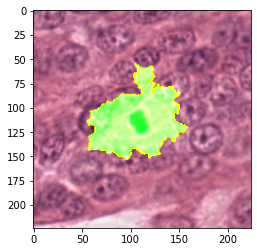

In [21]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)